In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor
from IPython.display import Markdown as md

In [this article](https://arxiv.org/abs/2211.06393) J. Bayron Orjuela-Quintana et al. have found an explicit expression for the transfer function T(k):

$$ T(k;\omega_b,\omega_m) = [1+59.0998\ x^{1.49177}+4658.01\ x^{4.02755}+3170.79\ x^{6.06}+150.089\ x^{7.28478}]^{-\frac{1}{4}} $$

where
$$ x=\frac{k\ Mpc}{\omega_m-\omega_b} $$

and $\omega_i=\Omega_i h^2$, where $h$ is the reduced Hubble constant and $\Omega_i$ are the density parameters where $X = b,c,m,r,\nu,\gamma$ denotes baryons, CDM, pressure-less matter, radiation, neutrinos, photons, respectively.

First of all, let's import T(k) from CLASS:

In [209]:
df_cl = pd.read_csv('TF_class.csv')
df_cus = pd.read_csv('TF_custom.csv')

Now, let's generate T(k)

In [210]:
def T(x):
    a = (1 + 59.0998 * x**1.49177 + 4658.01 * x**4.02755 + 3170.79 * x**6.06 + 150.089 * x**7.28478)**(-1/4)
    return a

In [211]:
h = 0.6781
k = np.logspace(np.log10(3 * 10 ** -5), np.log10(2),num=114,endpoint=True)
omega_b = 0.0223828 #omega baryon
omega_m = 0.1201075 #omega pressure-less matter
x = k/(omega_m-omega_b)
T_ = T(x)

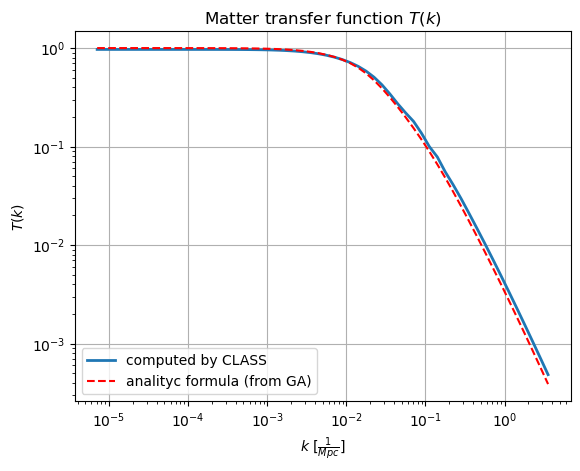

In [212]:
plt.plot(df_cus['k (1/Mpc)'],df_cus['T(k)'], label='computed by CLASS', lw=2)
plt.plot(df_cus['k (1/Mpc)'],T(df_cus['k (1/Mpc)']/(omega_m-omega_b)), label='analityc formula (from GA)', linestyle="--", color='r')
plt.xlabel(r'$k\ [\frac{1}{Mpc}]$')
plt.ylabel(r'$T(k)$')
plt.title(r"Matter transfer function $T(k)$")
plt.loglog()
plt.grid(True)
plt.legend()

I don't understand why I obtain a good accordance while I'm neglecting that the numerator of x is adimensional ($k\ Mpc$): in fact I used in the calculation only $k$, wich is dimensional ($[k]=\frac{1}{Mpc}$).

However, let's try to fit the analytic expression using PySR:

In [213]:
x = x.reshape(-1,1)
cluster = ["slurm", "pbs", "lsf", "sge", "qrsh", "scyld", "htc"]

In [214]:
model = PySRRegressor(
    model_selection="best",
    niterations=300,  # < Increase me for better results
    binary_operators=["+","*","-","/","^"],
    constraints={'^': (2, 1)},
    nested_constraints={"^": {"^": 2}},
    maxsize=20,
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    turbo=True,  
    #cluster_manager=cluster[1],
    #multithreading=True,
)

In [215]:
model.fit(x,T_)
print(model)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 3.590e+05
Head worker occupation: 13.9%
Progress: 627 / 4500 total iterations (13.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.781e-01  1.673e-07  0.58659303
3           4.449e-04  2.996e+00  (0.050597284 ^ x0)
5           3.039e-04  1.905e-01  ((0.041594874 ^ x0) + 0.015091164)
7           2.902e-04  2.308e-02  (((0.041643403 ^ x0) / 1.0066345) + 0.015091164)
9           2.643e-04  4.677e-02  ((((0.040790644 ^ x0) * 0.9850776) + 0.03910855) - 0.015102137...
                                  )
11          2.166e-05  1.251e+00  (x0 / ((((x0 ^ 1.3348308) / 0.123383656) * x0) + x0))
15          7.325e-06  2.711e-01  (x0 / (((x0 ^ 1.4024539) * (((x0 / 0.88195926) / 0.34950638) /...
                                   0.36304432)) + x0))
17          7.293e-06  2.123e-03  (x0 / (((x0 ^ 1.4024539) * ((((x0 + x0) / 0.88195

In [216]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $\frac{x_{0}}{x_{0} + x_{0}^{1.40} \cdot \left(8.86 x_{0} + 0.0125\right)}$

Text(0.5, 1.0, 'Relative difference between the formula and data')

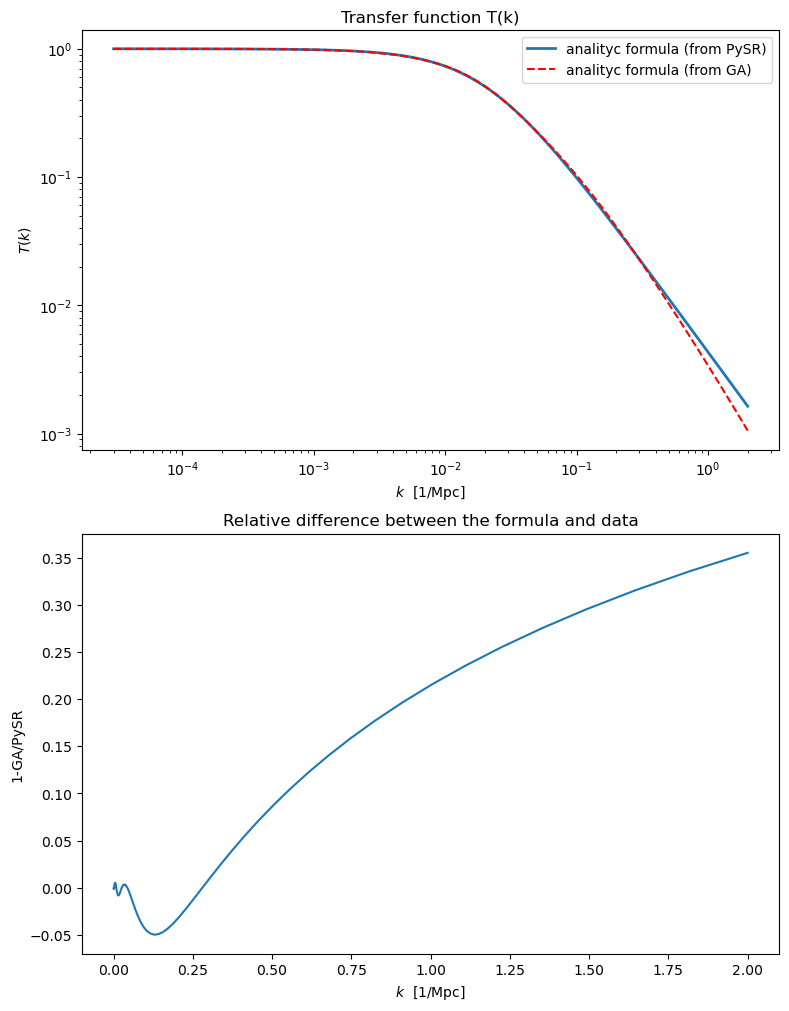

In [217]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,12))
pred = model.predict(x)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(k,pred, label='analityc formula (from PySR)', lw=2)
ax1.plot(k,T_, label='analityc formula (from GA)', linestyle="--", color='r')
ax1.set_xlabel(r'$k \,\,\,\, [1/\mathrm{Mpc}]$')
ax1.set_ylabel(r'$T(k)$')
ax1.set_title('Transfer function T(k)')
ax1.legend()

ax2.set_xlabel(r'$k \,\,\,\, [1/\mathrm{Mpc}]$')
ax2.set_ylabel(r'1-GA/PySR')
ax2.plot(k,1-T_/pred)
ax2.set_title('Relative difference between the formula and data')



It seems that the equation is too difficult to find it. Let's try for steps, with equations little by little more complicated:
n = k/(omega_m-omega_b)
y = T(n)
model.fit(x,y)
md(f"The model has this equation as output: ${model.latex()}$")
plt.plot(k,1-y/model.predict(x))
plt.semilogy(k,model.predict(x))
plt.semilogy(k,y)

# A new hope

Now we are generating data again with the analytic formula given by the paper, but now we are trying to replicate the choice of $k$ that they made.

(cit.) We consider that $\omega_b \in [0.0214,0.0234]$, and $\omega_m \in [0.13,0.15]$, and to see the dependence of the transfer function on these parameters, we make a grid of 4×4 pairs of $\{\omega_b, \omega_m\}$. For each considered cosmology (16 in total), we retrieve 114 points $\{k, T\}$. 

In [196]:
obar = np.linspace(0.0214, 0.0234, num=4, endpoint=True) #omega_b
omar = np.linspace(0.13, 0.15, num=4, endpoint=True) #omega_m

In [197]:
grid = [] #the pairs are (omega_b,omega_m)

for a in obar:
    line = []
    for b in omar:
        pair = (round(a, 4), round(b, 4))
        line.append(pair)
    grid.append(line)

Now, we calculate $x$:

In [198]:
k_ar = np.logspace(np.log10(3 * 10 ** -5), np.log10(2),num=114,endpoint=True)
x_1 = []
k_1 = []

for line in grid:
    for couple in line:
        a,b = couple
        x_1.append(k_ar/(b-a))
        k_1.append(k_ar)

x_1 = np.concatenate(x_1)
k_1 = np.concatenate(k_1)

Therefore, our preliminary dataset is composed by 1824 points. Now let's compute T(x) with the formula:

In [202]:
T_1 = T(x_1)

In [203]:
x_1 = x_1.reshape(-1,1)

In [204]:
model.fit(x_1,T_1)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1773: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 8.110e+04
Head worker occupation: 2.9%
Progress: 141 / 4500 total iterations (3.133%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.750e-01  8.505e-08  0.6029133
3           4.448e-04  2.987e+00  (0.0506017 ^ x0)
5           3.041e-04  1.902e-01  ((0.041645594 ^ x0) - -0.015057558)
7           3.041e-04  1.219e-05  ((0.04157938 ^ x0) - (-0.0091661485 / 0.608645))
9           1.907e-04  2.332e-01  (((0.041645594 ^ x0) + 0.17460282) / (1.1619053 + x0))
11          1.381e-04  1.613e-01  (((0.0598829 ^ x0) - -0.1666659) / (1.1472874 + (1.1472874 * x...
                                  0)))
13          2.026e-05  9.597e-01  (x0 / ((((x0 / 0.16862161) * 1.4002634) * (x0 ^ 1.343493)) + x...
                                  0))
17          1.441e-05  8.518e-02  (x0 / (((((x0 / (0.16862161 / 1.0335819)) + x0) + x0) * (x0 ^ ...


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                           0.602867   
	1        2.987390                                   (0.0506017 ^ x0)   
	2        0.190209                ((0.041586183 ^ x0) - -0.015031664)   
	3        0.085566    (((0.04040369 ^ x0) / 1.0168306) + 0.025498796)   
	4        0.373621      (x0 / (((x0 ^ 2.3798254) / 0.12925468) + x0))   
	5  >>>>  1.727912  (x0 / (((x0 ^ 2.3798254) / (0.12925468 * 0.901...   
	6        0.002501  (x0 / (((((x0 / 0.14874251) + (x0 ^ 1.7133493)...   
	7        0.012326  (x0 / (((((x0 / 0.14874251) + x0) + (x0 * (x0 ...   
	
	       loss  complexity  
	0  0.174993           1  
	1  0.000445           3  
	2  0.000304           5  
	3  0.000256           7  
	4  0.000121           9  
	5  0.000004          11  
	6  0.000004          17  
	7  0.000004          19  
]

In [205]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $\frac{x_{0}}{x_{0} + 8.59 x_{0}^{2.38}}$

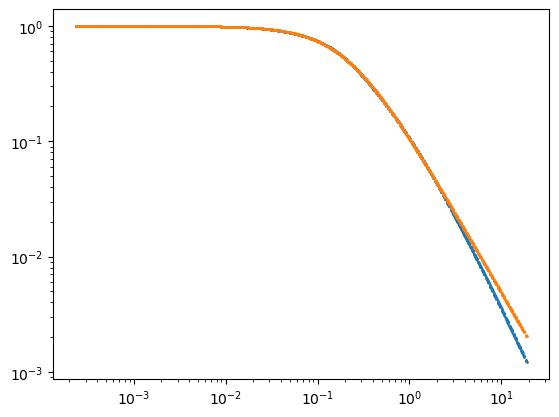

In [206]:
plt.scatter(x_1,T_1, s=1)
plt.loglog()
plt.scatter(x_1, model.predict(x_1), s=1)

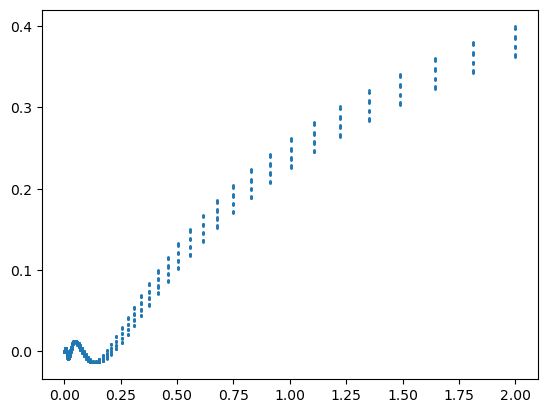

In [207]:
plt.scatter(k_1,1-T_1/model.predict(x_1),s=1)